# Aufgabe 2 - Tiefe Einblicke ins Institut

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

## Teilaufgabe a): Trainings-und Testdatenset

In [2]:
import os
import random
import math
import re

random.seed(322)

RE_FILE = re.compile(r"[a-zA-Z]+\d+\.jpg")


def create_data_split(folder, label: int, train_percent, test_percent, val_percent, base_only=True):
    """
    :param base_only: Only include base files, no augmented ones
    """

    assert train_percent + test_percent == 1, "train and test percentages dont add up to 1.0"
    assert 0 < val_percent <= 1, "validation percent must be within [0..1]"
    files = os.listdir(folder)
    if base_only:
        files = [f for f in files if RE_FILE.match(f)]
    random.shuffle(files)

    train_cnt = math.ceil(len(files) * train_percent)
    val_cnt = math.ceil(train_cnt * val_percent)
    train_files = [f'{folder}/{f}' for f in files[:train_cnt]]
    test_files = [f'{folder}/{f}' for f in files[train_cnt:]]
    valid_files = train_files[:val_cnt]

    random.shuffle(train_files)
    random.shuffle(test_files)
    random.shuffle(valid_files)

    return list(zip(train_files, [label] * len(train_files))), \
        list(zip(test_files, [label] * len(test_files))), \
        list(zip(valid_files, [label] * len(valid_files)))


def create_full_data_split(base_only=True):
    train_percent = 0.7
    test_percent = 0.3
    val_percent = 0.3

    flur_train, flur_test, flur_val = create_data_split('Bilder/Flur', 0, train_percent, test_percent, val_percent,
                                                        base_only)
    labo_train, labo_test, labo_val = create_data_split('Bilder/Labor', 1, train_percent, test_percent, val_percent,
                                                        base_only)
    prof_train, prof_test, prof_val = create_data_split('Bilder/Professorenbuero', 2, train_percent, test_percent,
                                                        val_percent, base_only)
    teek_train, teek_test, teek_val = create_data_split('Bilder/Teekueche', 3, train_percent, test_percent, val_percent,
                                                        base_only)

    train_files = flur_train + labo_train + prof_train + teek_train
    test_files = flur_test + labo_test + prof_test + teek_test
    val_files = flur_val + labo_val + prof_val + teek_val

    random.shuffle(train_files)
    random.shuffle(test_files)
    random.shuffle(val_files)

    train_batch_len = (len(train_files) // 16) * 16
    test_batch_len = (len(test_files) // 16) * 16
    val_batch_len = (len(val_files) // 16) * 16

    return (
        [f[0] for f in train_files][:train_batch_len],
        [f[1] for f in train_files][:train_batch_len],
        [f[0] for f in test_files][:test_batch_len],
        [f[1] for f in test_files][:test_batch_len],
        [f[0] for f in val_files][:val_batch_len],
        [f[1] for f in val_files][:val_batch_len],
    )


# Labels are: Flur=0, Labor=1, Professorenbuero=2, Teekueche=3
training_path_list, training_label_list, test_path_list, test_label_list, _, _ = create_full_data_split(base_only=True)


## Teilaufgabe b): Verteilung RGB

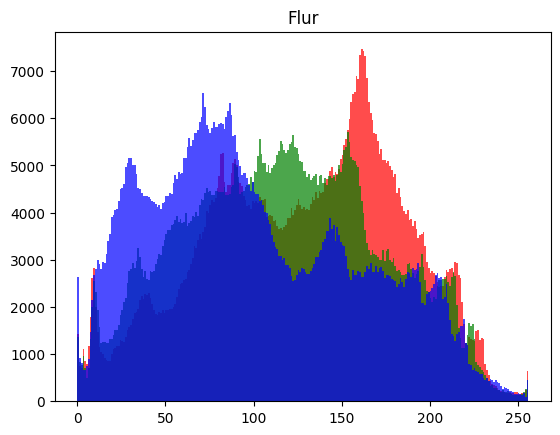

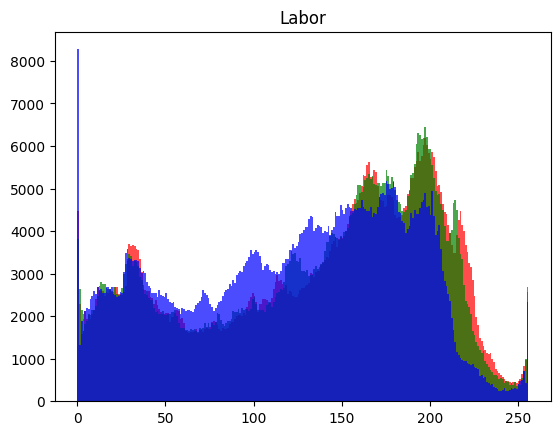

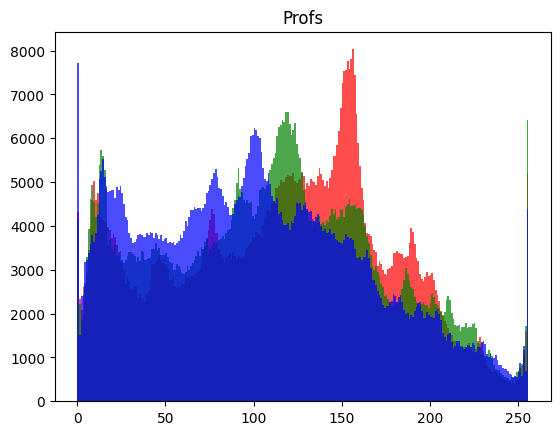

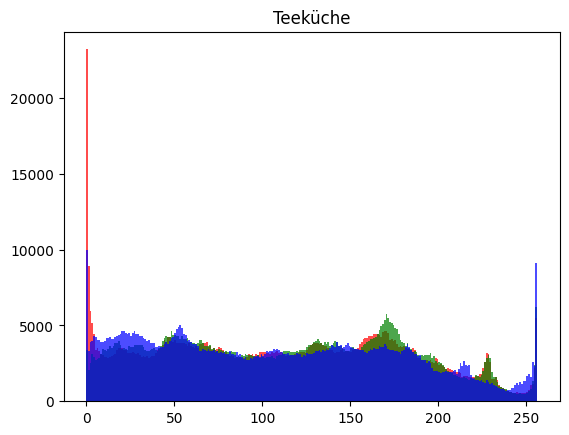

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def picture_to_rgb(directory):  # Splitted Bild in Farbkanäle und returned dessen Werte
    image = Image.open(directory)
    data = np.array(image)
    red, green, blue = data[:, :, 0], data[:, :, 1], data[:, :, 2]
    red = red.flatten()
    green = green.flatten()
    blue = blue.flatten()
    return red, green, blue


def draw_histo(data, name):  # Printed das Histogramm der einzelnen Räume
    plt.title(name)
    plt.hist(data[0], color='red', alpha=0.7, bins=256, range=[0, 256])
    plt.hist(data[1], color='green', alpha=0.7, bins=256, range=[0, 256])
    plt.hist(data[2], color='blue', alpha=0.7, bins=256, range=[0, 256])
    plt.show()


# Splitted die Trainingsdaten nochmal nach Räumen auf, damit mehrere Histogramme ausgegeben werden können
flur = [i for i, x in enumerate(training_label_list) if x == 0]
labor = [i for i, x in enumerate(training_label_list) if x == 1]
professorenbuero = [i for i, x in enumerate(training_label_list) if x == 2]
teekueche = [i for i, x in enumerate(training_label_list) if x == 3]
room_names = ["Flur", "Labor", "Profs", "Teeküche"]
room_directory_collection = [flur, labor, professorenbuero, teekueche]

# Iteriert durch die Räume einmal durch, speichert die RGB Werte & gibt sie abschließend als Histogramm aus.
i = 0
for name in room_names:
    data = [[], [], []]
    for picture_index in room_directory_collection[i]:
        red, green, blue = picture_to_rgb(training_path_list[picture_index])
        data[0].extend(red)
        data[1].extend(green)
        data[2].extend(blue)
    draw_histo(data, name)
    i = i + 1

## Teilaufgabe c): Training und Test mit Random Forest 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

training_data = []
test_data = []

# Speichert die Test & Trainingsdaten nochmal als RGB
for file in training_path_list:
    red, green, blue = picture_to_rgb(file)
    training_data.append(np.concatenate([red, green, blue]))

for file in test_path_list:
    red, green, blue = picture_to_rgb(file)
    test_data.append(np.concatenate([red, green, blue]))

# Training mit den RGB Daten im Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(training_data, training_label_list)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data)
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction,
                              average='macro'))  # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction,
                          labels=[0, 1, 2, 3])  # Matrix
print(matrix)

Accuracy -  0.625
F1-Score -  0.6111111111111112
Recall -  0.625
Precision -  0.725
[[4 0 0 0]
 [0 3 1 0]
 [0 2 2 0]
 [0 1 2 1]]


## Teilaufgabe d): Hyperparameteroptimierung

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Finde den besten Wert der drei, um die Tiefe des Forests zu beschneiden
param_grid = {
    'max_depth': [30, 50, 70]}  # Bei diesen Werten klassifiziert er den 4ten Raum leicht besser, aber 2 schlechter.
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)  # 5 Folds

# Training und Ausgabe
grid_search.fit(training_data, training_label_list)
print("Beste Hyperparameter: ", grid_search.best_params_)
forest = RandomForestClassifier(n_estimators=grid_search.best_params_['max_depth'])

# Das neue Modell mit den Trainingsdaten trainieren
forest.fit(training_data, training_label_list)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data)  # Diesmal mit dem neuen Kriterium
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction,
                              average='macro'))  # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction,
                          labels=[0, 1, 2, 3])  # Matrix
print(matrix)

Beste Hyperparameter:  {'max_depth': 30}
Accuracy -  0.75
F1-Score -  0.746031746031746
Recall -  0.75
Precision -  0.7666666666666666
[[4 0 0 0]
 [0 3 1 0]
 [1 1 2 0]
 [0 1 0 3]]


## Teilaufgabe e): Dimensionalitätsreduktion

In [9]:
from sklearn.decomposition import PCA

# PCA auf Trainingsdaten anwenden und Varianz einstellen. Bei 0.85 bisher beste Leistung
pca = PCA(n_components=0.85)
pca_training_data = pca.fit_transform(training_data)
forest = RandomForestClassifier(n_estimators=100)
forest.fit(pca_training_data, training_label_list)

# Testdaten anpassen
test_data_pca = pca.transform(test_data)

# Erfolg des Trainings wird anhand der Testdaten überprüft
prediction = forest.predict(test_data_pca) # Diesmal mit dem neuen Kriterium
print("Accuracy - ", accuracy_score(test_label_list, prediction))
print("F1-Score - ", f1_score(test_label_list, prediction, average='macro')) # Könnte auch weighted sein, Macro liefert aber bessere Ergebnisse
print("Recall - ", recall_score(test_label_list, prediction, average='macro'))
print("Precision - ", precision_score(test_label_list, prediction, average='macro'))
matrix = confusion_matrix(test_label_list, prediction, labels = [0, 1, 2, 3]) # Matrix
print(matrix)

Accuracy -  0.75
F1-Score -  0.7333333333333333
Recall -  0.75
Precision -  0.8333333333333333
[[4 0 0 0]
 [0 4 0 0]
 [0 2 2 0]
 [2 0 0 2]]
